<a href="https://colab.research.google.com/github/jangdain04-lab/TA_Airpods/blob/main/TA_obj2_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yeon524/kpop-lyrics-analytics.git
!ls kpop-lyrics-analytics

Cloning into 'kpop-lyrics-analytics'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 196 (delta 3), reused 9 (delta 3), pack-reused 185 (from 1)
Receiving objects: 100% (196/196), 41.17 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Updating files: 100% (38/38), done.
analytics_kiwi.ipynb	       clustering.ipynb  lda.html    requirements.txt
analytics_konlpy.ipynb	       datasets		 lyrics.d2v
analytics_repeatability.ipynb  docs		 README.md


In [2]:
!ls kpop-lyrics-analytics/datasets

language_ratio_per_year.csv   lyrics_word_count_kiwi.csv
lyrics_by_year_1964_2023.csv  lyrics_word_count_konlpy.csv


In [3]:
import pandas as pd

# 1) CSV 불러오기
df = pd.read_csv("kpop-lyrics-analytics/datasets/lyrics_by_year_1964_2023.csv")

# 2) 연도 필터링 (1970~2019)
df = df[(df['year'] >= 1970) & (df['year'] <= 2019)].copy()

# 3) 가사 없는 데이터 제거
df = df.dropna(subset=['lyric'])

# 4) 최종 확인
df.head(), df.shape

(          id  year      title singer  \
 171  4058660  1970      소양강처녀    김태희   
 173  3773396  1970  가는 정 오는 정    남정희   
 175  3622569  1970  이정표 없는 거리    김상진   
 176  3621632  1970  아마도 빗물이겠지    이상열   
 177  3621631  1970        난이야    이상열   
 
                                                  lyric  x_rated  
 171  해 저문 소양강에 황혼이 지면\n외로운 갈대 밭이\n슬피 우는 두견새야\n열 여덣 ...    False  
 173  아롱진 옷자락에\n서글픈 사연 안고\n내 마음은 울면서도\n겉으로는 웃으며\n사랑도...    False  
 175  이리 가면 고향이오\n저리 가면 타향인데\n이정표 없는 거리\n헤매 도는 삼거리 길...    False  
 176  맺지 못할 사랑이기에\n말없이 헤어졌고\n돌아서는 두발 길에\n이슬비는 내리네\n사...    False  
 177  난이야 난이야\n사랑을 모두 주고\n울며 떠나간 너 바보구나\n때늦은 후회지만\n너...    False  ,
 (3914, 6))

In [4]:
# 필터링: 1970 ~ 2019
df = df[(df['year'] >= 1970) & (df['year'] <= 2019)].copy()

# 가사 없는 행 제거
df = df.dropna(subset=['lyric'])

In [5]:
# year → decade (예: 1973 → 1970, 1998 → 1990)
df['decade'] = (df['year'] // 10) * 10

df[['year', 'decade']].head()
df['decade'].value_counts().sort_index()

,count
decade,
1970,332
1980,677
1990,942
2000,998
2010,965


**1. LDA (Latent Dirichlet Allocation)**

LDA는 Topic Modeling을 위한 전통적인 확률 기반 모델이다.
문서(가사)를 여러 주제(Topic)의 혼합으로 보고,각 Topic은 단어들의 확률 분포로 구성된다고 가정한다.

🔹 핵심 개념

문서 = 여러 토픽의 비율로 구성
토픽 = 단어들의 확률 분포
단어가 자주 함께 등장하면 하나의 토픽으로 묶는다

🔹 작동 방식 (직관적으로)

가사 안에서 자주 같이 등장하는 단어들을 찾는다.
그 단어 묶음을 “토픽”이라고 부른다.
모든 문서가 어떤 토픽에 얼마나 속하는지 확률로 나타낸다.

🔹 장점

가장 널리 알려지며 해석이 쉽다
수학적 구조가 명확하고 학술 자료가 많다
비교적 빠르고 안정적이다

🔹 단점

단어 의미(semantic)를 이해하지 못함
동의어/비유/문장 표현의 뉘앙스는 반영 안 됨
한국어처럼 조사·활용 많은 언어에서는 성능 떨어짐
토픽 개수(num_topics)를 사용자가 직접 결정해야 함

🔹 언제 적합한가?

baseline 모델이 필요할 때
단순 단어 패턴 기반 토픽을 보고 싶을 때

In [6]:
!pip install kiwipiepy
from kiwipiepy import Kiwi

kiwi = Kiwi()

stopwords_ko = set([
    "그대","그댈","그녀","내가","나는","나를","너","너를","너와","우리",
    "오늘","이제","정말","그냥","다시","조금","아주","마음","가슴","너무",
    "이리","저리","그리고","하지만","그래서","또한"
])

def tokenize(text):
    if not isinstance(text, str):
        return []
    tokens = []
    for t in kiwi.tokenize(text):
        w = t.form
        pos = t.tag

        # 길이 2 이상 & 불용어 제거 & 명사/동사/형용사 중심
        if len(w) > 1 and w not in stopwords_ko and pos.startswith(("N","V","M")):
            tokens.append(w)
    return tokens

df["tokens"] = df["lyric"].apply(tokenize)

df["tokens"].head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.5 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.22.0-py3-none-any.whl size=79625203 sha256=378189c6867e4788dc296fcdcb5016af44efda348cf397c8d9813c1150674f45
  Stored in directory: /root/.cache/pip/wheels/e5/4b/3f/aa850a40d0f9709fd4c6d37d48402ca95354264236e1205ea3
Successfully built kiwipiepy_model


,tokens
171,"[저물, 소양강, 황혼, 외롭, 갈대, 슬피, 두견, 여덣, 딸기, 어리, 순정, ..."
173,"[아롱, 옷자락, 서글프, 사연, 사랑, 이름, 상처, 상처, 사랑, 사람, 모르,..."
175,"[고향, 타향, 이정표, 거리, 헤매, 삼거리, 차라리, 갈래, 삼거리, 내리, 바..."
176,"[못하, 사랑, 말없이, 헤어지, 돌아서, 이슬, 내리, 사나이, 까짓, 사랑, 때..."
177,"[사랑, 모두, 떠나가, 바보, 때늦, 후회, 사랑, 목메, 부르, 산울림, 흩어지..."


In [7]:
!pip install gensim
from gensim import corpora, models

texts = df["tokens"].tolist()

# 단어 사전
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=20, no_above=0.6)

corpus = [dictionary.doc2bow(text) for text in texts]

num_topics = 8    # 👉 토픽 8개 정도 추천 (원하면 4개도 가능)

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

lda_topics = lda_model.print_topics(num_words=10)
for i, t in lda_topics:
    print(f"[LDA 토픽 {i}]\n{t}\n")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 83.4 MB/s eta 0:00:00
[LDA 토픽 0]
0.039*"아니" + 0.021*"떠나" + 0.019*"위하" + 0.018*"제발" + 0.016*"돌아오" + 0.016*"지금" + 0.015*"버리" + 0.015*"멈추" + 0.014*"이렇" + 0.014*"기다리"

[LDA 토픽 1]
0.041*"세상" + 0.022*"하나" + 0.020*"행복" + 0.016*"모두" + 0.016*"함께" + 0.015*"사람" + 0.013*"그렇" + 0.013*"지키" + 0.013*"위하" + 0.012*"보이"

[LDA 토픽 2]
0.062*"사람" + 0.038*"노래" + 0.033*"부르" + 0.033*"떠나" + 0.029*"슬프" + 0.022*"떠나가" + 0.021*"눈물" + 0.018*"혼자" + 0.018*"그립" + 0.013*"때문"

[LDA 토픽 3]
0.023*"만나" + 0.022*"사람" + 0.020*"생각" + 0.016*"누구" + 0.014*"지금" + 0.013*"시간" + 0.013*"그렇" + 0.011*"다른" + 0.011*"모든" + 0.010*"얘기"

[LDA 토픽 4]
0.024*"눈물" + 0.019*"내리" + 0.018*"모습" + 0.016*"추억" + 0.015*"바람" + 0.015*"기억" + 0.015*"기다리" + 0.014*"시간" + 0.014*"돌아오" + 0.013*"아름답"

[LDA 토픽 5]
0.050*"모르" + 0.040*"여자" + 0.034*"남자" + 0.032*"미치" + 0.020*"친구" + 0.015*"자꾸" + 0.014*"그렇" + 0.012*"세상" + 0.011*"어디" + 0.011*"그것"

[LDA 토픽 6]
0.031*"아프" + 0.029*"눈물" + 0.028*"버리" + 0.023*"모르" + 0.021*"기억" +

In [10]:
# LDA: 곡별 가장 높은 토픽 번호 붙이기
def get_main_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    # (topic_id, prob) 중에서 prob가 가장 큰 토픽 선택
    main_topic = max(topics, key=lambda x: x[1])[0]
    return main_topic

df["lda_main_topic"] = [get_main_topic(lda_model, bow) for bow in corpus]
df[["year", "decade", "title", "lda_main_topic"]].head()


,year,decade,title,lda_main_topic
171,1970,1970,소양강처녀,2
173,1970,1970,가는 정 오는 정,2
175,1970,1970,이정표 없는 거리,2
176,1970,1970,아마도 빗물이겠지,2
177,1970,1970,난이야,4


In [11]:
# 토픽 단어 다시 확인 (이미 했으면 스킵 가능)
for i, topic in lda_model.print_topics(num_topics=8, num_words=10):
    print(f"[토픽 {i}] {topic}")


[토픽 0] 0.039*"아니" + 0.021*"떠나" + 0.019*"위하" + 0.018*"제발" + 0.016*"돌아오" + 0.016*"지금" + 0.015*"버리" + 0.015*"멈추" + 0.014*"이렇" + 0.014*"기다리"
[토픽 1] 0.041*"세상" + 0.022*"하나" + 0.020*"행복" + 0.016*"모두" + 0.016*"함께" + 0.015*"사람" + 0.013*"그렇" + 0.013*"지키" + 0.013*"위하" + 0.012*"보이"
[토픽 2] 0.062*"사람" + 0.038*"노래" + 0.033*"부르" + 0.033*"떠나" + 0.029*"슬프" + 0.022*"떠나가" + 0.021*"눈물" + 0.018*"혼자" + 0.018*"그립" + 0.013*"때문"
[토픽 3] 0.023*"만나" + 0.022*"사람" + 0.020*"생각" + 0.016*"누구" + 0.014*"지금" + 0.013*"시간" + 0.013*"그렇" + 0.011*"다른" + 0.011*"모든" + 0.010*"얘기"
[토픽 4] 0.024*"눈물" + 0.019*"내리" + 0.018*"모습" + 0.016*"추억" + 0.015*"바람" + 0.015*"기억" + 0.015*"기다리" + 0.014*"시간" + 0.014*"돌아오" + 0.013*"아름답"
[토픽 5] 0.050*"모르" + 0.040*"여자" + 0.034*"남자" + 0.032*"미치" + 0.020*"친구" + 0.015*"자꾸" + 0.014*"그렇" + 0.012*"세상" + 0.011*"어디" + 0.011*"그것"
[토픽 6] 0.031*"아프" + 0.029*"눈물" + 0.028*"버리" + 0.023*"모르" + 0.021*"기억" + 0.017*"그렇" + 0.017*"아직" + 0.015*"지우" + 0.014*"이렇" + 0.013*"보내"
[토픽 7] 0.052*"당신" + 0.039*"하늘" + 0.017*"바람" + 0.0

In [19]:
lda_topic_names_en = {
    0: "Holding On (Breakup)",
    1: "Hope · Comfort · Togetherness",
    2: "Sadness · Longing",
    3: "Relationships · Worries · Daily Life",
    4: "Reminiscence · Emotional Breakup",
    5: "Complex Romantic Feelings",
    6: "Post-Breakup Pain",
    7: "Poetic Sensibility · Nature Imagery"
}


df["lda_topic_name"] = df["lda_main_topic"].map(lda_topic_names_en)
df[["year", "decade", "title", "lda_main_topic", "lda_topic_name"]].head()


,year,decade,title,lda_main_topic,lda_topic_name
171,1970,1970,소양강처녀,2,Sadness · Longing
173,1970,1970,가는 정 오는 정,2,Sadness · Longing
175,1970,1970,이정표 없는 거리,2,Sadness · Longing
176,1970,1970,아마도 빗물이겠지,2,Sadness · Longing
177,1970,1970,난이야,4,Reminiscence · Emotional Breakup


In [20]:
decade_topic_table = df.groupby(["decade", "lda_topic_name"]).size().unstack(fill_value=0)
decade_topic_table

lda_topic_name,Complex Romantic Feelings,Holding On (Breakup),Hope · Comfort · Togetherness,Poetic Sensibility · Nature Imagery,Post-Breakup Pain,Relationships · Worries · Daily Life,Reminiscence · Emotional Breakup,Sadness · Longing
decade,,,,,,,,
1970,14,8,25,111,11,15,70,78
1980,33,13,30,160,61,41,202,137
1990,48,76,153,69,171,175,173,77
2000,55,115,143,37,370,172,54,52
2010,119,124,111,35,210,261,65,40


In [21]:
decade_topic_ratio = decade_topic_table.div(decade_topic_table.sum(axis=1), axis=0)
decade_topic_ratio


lda_topic_name,Complex Romantic Feelings,Holding On (Breakup),Hope · Comfort · Togetherness,Poetic Sensibility · Nature Imagery,Post-Breakup Pain,Relationships · Worries · Daily Life,Reminiscence · Emotional Breakup,Sadness · Longing
decade,,,,,,,,
1970,0.042169,0.024096,0.075301,0.334337,0.033133,0.045181,0.210843,0.234940
1980,0.048744,0.019202,0.044313,0.236337,0.090103,0.060561,0.298375,0.202363
1990,0.050955,0.080679,0.162420,0.073248,0.181529,0.185775,0.183652,0.081741
2000,0.055110,0.115230,0.143287,0.037074,0.370741,0.172345,0.054108,0.052104
2010,0.123316,0.128497,0.115026,0.036269,0.217617,0.270466,0.067358,0.041451


<Axes: xlabel='decade'>

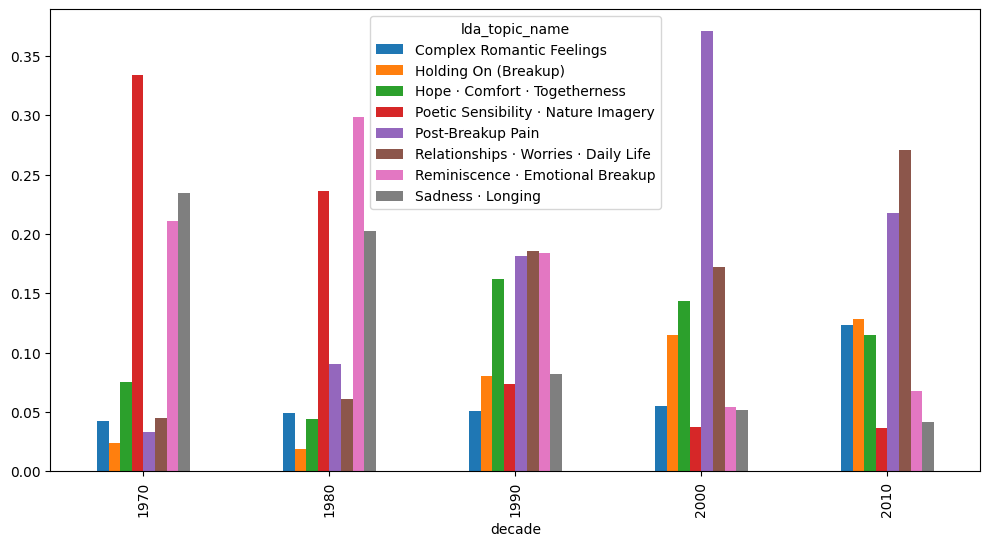

In [22]:
decade_topic_ratio.plot(kind="bar", figsize=(12, 6))

**2. NMF (Non-Negative Matrix Factorization)**

NMF는 TF-IDF 기반 행렬을 단어–토픽” 과 “문서–토픽” 행렬로 분해하는 방식의 Topic Modeling이다.

🔹 핵심 개념

TF-IDF 행렬을 양수 조건으로 분해(Non-Negative)
각 토픽을 대표하는 단어들이 비교적 명확하게 드러남
단어 기반 토픽 해석이 LDA보다 직관적일 때도 많음

🔹 작동 방식

전체 문서를 TF-IDF로 벡터화
이 행렬을 W(문서-토픽), H(토픽-단어)로 분해
H에서 큰 값을 가진 단어들이 해당 토픽의 대표 단어가 됨

🔹 장점

LDA보다 토픽이 더 “선명”하게 나타나는 경우가 많다
구현이 간단하고 속도가 빠르다
고차원 데이터(TF-IDF)에 잘 맞음

🔹 단점

LDA처럼 토픽 의미를 자연스럽게 뽑아주는 구조는 아님
단어 의미를 이해하지 못함
토픽 개수(n_components)를 사용자가 결정해야 함
문맥 기반 의미 파악은 불가능

🔹 언제 적합한가?

TF-IDF 기반 토픽을 보고 싶을 때
단순하고 선명한 토픽 분해가 필요할 때
LDA와 비교 실험을 하고 싶을 때

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

docs_for_tfidf = [" ".join(t) for t in df["tokens"]]

tfidf = TfidfVectorizer(max_df=0.6, min_df=20, ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(docs_for_tfidf)

num_topics = 8

nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

feature_names = tfidf.get_feature_names_out()

def print_nmf_topics(H, names, topn=10):
    for i, topic in enumerate(H):
        top_words = [names[j] for j in topic.argsort()[::-1][:topn]]
        print(f"[NMF 토픽 {i}] {' / '.join(top_words)}\n")

print_nmf_topics(H, feature_names)


[NMF 토픽 0] 눈물 / 아프 / 기억 / 보내 / 이별 / 추억 / 사랑 사랑 / 슬프 / 지우 / 아직

[NMF 토픽 1] 당신 / 당신 사랑 / 사랑 당신 / 당신 당신 / 아름답 / 사랑 사랑 / 드리 / 떠나가 / 바치 / 세월

[NMF 토픽 2] 모르 / 그렇 / 여자 / 남자 / 아니 / 자꾸 / 이렇 / 생각 / 누구 / 미치

[NMF 토픽 3] 세상 / 함께 / 모든 / 위하 / 모두 / 하나 / 행복 / 느끼 / 순간 / 지키

[NMF 토픽 4] 사람 / 사랑 사람 / 사람 사랑 / 사람 사람 / 만나 / 행복 / 사람 만나 / 다른 / 다른 사람 / 누구

[NMF 토픽 5] 바람 / 하늘 / 내리 / 외롭 / 멀리 / 거리 / 어디 / 구름 / 하얗 / 그립

[NMF 토픽 6] 노래 / 부르 / 노래 부르 / 사랑 노래 / 슬프 노래 / 슬프 / 같이 / 이름 / 친구 / 소리

[NMF 토픽 7] 떠나 / 버리 / 돌아오 / 떠나가 / 떠나 버리 / 제발 / 떠나 사랑 / 남기 / 사랑 떠나 / 모습



/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


**3. BERT 기반 Topic Modeling (예: BERTopic)**

BERTopic은 최근 가장 많이 쓰이는 딥러닝 기반 Topic Modeling 기법이다.
BERT 임베딩을 활용해 문장의 의미(semantic) 를 이해할 수 있다.

🔹 핵심 개념

BERT가 문장 임베딩을 생성하여 의미 기반으로 문서를 표현
유사한 의미의 문장끼리 자동 클러스터링
클러스터마다 c-TF-IDF로 대표 단어를 추출 → Topic 생성
토픽 개수를 사용자가 정하지 않아도 됨 (HDBSCAN 기반)

🔹 작동 방식

BERT로 문장 임베딩 생성 (의미를 벡터로 표현)
UMAP으로 차원 축소
HDBSCAN으로 자동 군집화
각 군집에 대해 c-TF-IDF로 대표 단어 생성 → Topic 완성

🔹 장점

한국어 의미를 실제로 이해함
(사랑해 vs 널 그리워 vs 보고 싶어 → 모두 유사한 감정 표현으로 인식)
동의어·비유·문맥까지 반영 가능
토픽 개수 자동 결정
결과 토픽들이 더 자연스럽고 해석하기 쉬움
BERTopic은 시각화 기능 내장

🔹 단점

전통 방식보다 느림
GPU 사용 시 가장 효과적
완전히 자동이기 때문에 토픽이 너무 많아질 수 있음
(reduce_topics로 정리 가능)

🔹 언제 적합한가?

한국어 가사처럼 문맥·감정 표현이 중요한 데이터
의미 기반 토픽이 필요할 때
최신 딥러닝 Topic Modeling을 적용하고 싶을 때
OBJ2에서 가장 중요한 모델로 사용하기 좋음

In [9]:
!pip install bertopic sentence-transformers umap-learn hdbscan

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

docs = df["lyric"].astype(str).tolist()

embedding_model = SentenceTransformer("jhgan/ko-sroberta-multitask")

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="multilingual",
    verbose=True
)

topics, probs = topic_model.fit_transform(docs)

df["topic_bertopic"] = topics
topic_model.get_topic_info()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-12-07 06:29:28,201 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/123 [00:00<?, ?it/s]

KeyboardInterrupt: 